In [63]:
using Pkg; for p in ["MLDatasets"]; Pkg.add(p); end
import Pkg; Pkg.add("PyPlot")
using PyPlot
using Printf, Random, Test, Statistics
using MLDatasets
using Knet
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using Plots; default(fmt=:png,ls=:auto)

  Resolving package versions...
No Changes to `C:\Users\Ahmed Imam Shah\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\Ahmed Imam Shah\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
  Installed PyPlot ─ v2.9.0
  Installed PyCall ─ v1.92.1
Updating `C:\Users\Ahmed Imam Shah\.julia\environments\v1.5\Project.toml`
  [d330b81b] + PyPlot v2.9.0
Updating `C:\Users\Ahmed Imam Shah\.julia\environments\v1.5\Manifest.toml`
  [438e738f] + PyCall v1.92.1
  [d330b81b] + PyPlot v2.9.0
   Building PyCall → `C:\Users\Ahmed Imam Shah\.julia\packages\PyCall\BcTLp\deps\build.log`
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278
┌ Info: Installing matplotlib via the Conda matplotlib package...
└ @ PyCall C:\Users\Ahmed Imam Shah\.julia\packages\PyCall\BcTLp\src\PyCall.jl:708
┌ Info: Running `conda install -y matplotlib` in root environment
└ @ Conda C:\Users\Ahmed Imam Shah\.julia\packages\Conda\3rPhK\src\Conda.jl:113


Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Ahmed Imam Shah\.julia\conda\3

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cycler-0.10.0              |           py38_0          14 KB
    freetype-2.10.4            |       hd328e21_0         466 KB
    kiwisolver-1.3.0           |   py38hd77b12b_0          78 KB
    libtiff-4.1.0              |       h56a325e_1         739 KB
    lz4-c-1.9.2                |       hf4a77e7_3         106 KB
    matplotlib-3.3.2           |                0          25 KB
    matplotlib-base-3.3.2      |   py38hba9282a_0         5.1 MB
    olefile-0.46               |             py_0          33 KB
    pillow-8.0.1               |   py38h4fa10fc_0         690 KB
    tk-8.6.10                  |       he774522_0         2.7 MB
    xz-5.2.5                   |    

Matplotlib is building the font cache; this may take a moment.


In [26]:
# load full training set
train_x, train_y = MNIST.traindata();

# load full test set
test_x,  test_y  = MNIST.testdata();

size(train_x), size(train_y), size(test_x), size(test_y)

((28, 28, 60000), (60000,), (28, 28, 10000), (10000,))

In [31]:
struct MnistData
    x
    y
    batchsize::Int
    shuffle::Bool
    num_instances::Int

    function MnistData(x, y; batchsize::Int=100, shuffle::Bool=false, dtype::Type=Array{Float64})
        # Your code here
        
        batch_x::dtype = x
        batch_y::dtype = y
        
        new(batch_x,batch_y, batchsize, shuffle, length(y))
    end
end


In [32]:
"""
    length(d::MnistData)

Return how many minibatches dataset `d` has.
"""
function length(d::MnistData)
    # Your code here
    quotient, remainder = divrem(d.num_instances, d.batchsize)
    if remainder>0
        return quotient + 1
    else
        return quotient
    end
end


Base.length

In [37]:
"""
    iterate(d::MnistData[, state])

Iterate over `d::MnistData` object. If `state` is missing, it's the beginning
of the whole iteration process.
"""
function iterate(d::MnistData, state=ifelse(
    d.shuffle, randperm(d.num_instances), collect(1:d.num_instances)))
    # Your code here
    
    if length(state) > 0 
        
        if length(state) >= d.batchsize
            batch_x = d.x[:,:, state[1:d.batchsize]]
            batch_y = d.y[:, state[1:d.batchsize]]
        else
            batch_x = d.x[:,:, state[1:end]]
            batch_y = d.y[:, state[1:end]]

        end
        state = state[d.batchsize+1:end]
        return (batch_x, batch_y), state
    end
    
end

Base.iterate

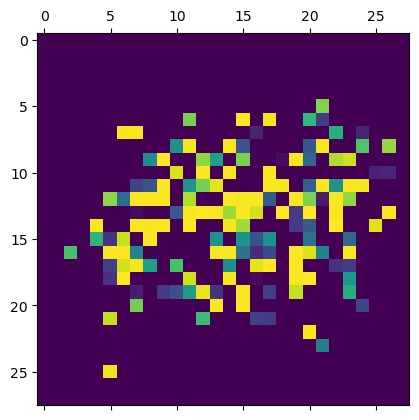

PyObject <matplotlib.image.AxesImage object at 0x000000005A6DB9A0>

In [102]:
"""
    predictPixel(image)

predicts the value of the pixel based on the previous pixel values
The pixels in the input image given as the parameter will be used to predict the pixel.
This function will return the probabilities of the functions that will be used to calculate the loss.
"""
function predictPixel(image, i, j)
    random_index = rand(1:60000,size(image));
    randPixel = train_x[i,j,random_index[i,j]]
end

"""
    generateImage()

uses `predictPixel` function recursively to generate entire image.

"""
function generateImage()
    img = zeros(28,28);
    for i in 1:28
        for j in 1:28
            img[i,j] = predictPixel(img, i, j)
        end
    end
    return img;
end

Knet.seed!(2)
image=generateImage()

matshow(image)

In [104]:
mask3 = reshape([1.0,1.0,0,1.0,0,0,1,0,0],(3,3,1,1))

3×3×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0  1.0  1.0
 1.0  0.0  0.0
 0.0  0.0  0.0

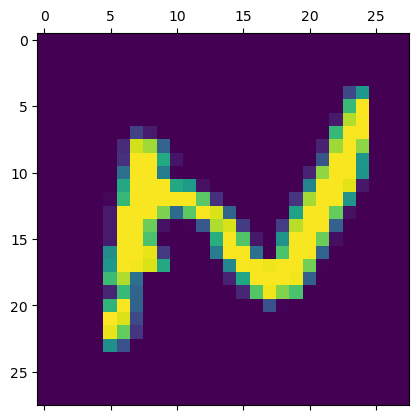

PyObject <matplotlib.image.AxesImage object at 0x00000000617FC130>

In [71]:
#training data sample image
true_image = train_x[:,:,1]
matshow(true_image)

In [80]:
function softloss(ygold, ypred)
    ynorm = ypred .- log.(sum(exp(ypred),dims=1))
    -sum(ygold .* ynorm) / size(ygold,2)
end

softloss (generic function with 1 method)

In [81]:
softloss(true_image, image)

15.747331824910194

In [39]:
obj1 = MnistData(train_x, train_y; batchsize=5000, dtype=Array{Float32}, shuffle=true)
@test obj1.shuffle == true
@test typeof(obj1.x) <: Array{Float32}
@test typeof(obj1.y) <: Array{Float32}
@test obj1.batchsize == 5000
@test obj1.num_instances == 60000

Test Passed

In [82]:
@doc nll

```
nll(scores, labels; dims=1, average=true)
```

Return the negative log likelihood for a single batch of data given an unnormalized `scores` matrix and an `Integer` array of correct `labels`. The `scores` matrix should have size `(classes,instances)` if `dims=1` or `(instances,classes)` if `dims=2`. `labels[i]` should be in `1:classes` to indicate the correct class for instance i, or 0 to skip instance i.

The return value is `(total/count)` if `average=true` and `(total,count)` if `average=false` where `count` is the number of instances not skipped (i.e. `label != 0`) and `total` is their total negative log likelihood.

## Example

Let's assume that there are three classes (cat, dog, ostrich) and just 2 instances with the unnormalized score `scores[:,1]` and `scores[:,2]` respectively. The first instance is actually a cat and the second instance a dog:

```
scores = [12.2    0.3;
           2.0   21.5;
           0.0  -21.0]
labels = [1, 2]
nll(scores,labels)
# returns 2.1657e-5
```

The probabilites are derived from the scores and the negative log-probabilities corresponding to the labels are averaged:

```
probabilites = exp.(scores) ./ sum(exp.(scores),dims=1)
-(log(probabilites[labels[1],1]) + log(probabilites[labels[2],2]))/2
# returns 2.1657e-5
```

```
nll(model; data, dims=1, average=true, o...)
```

Compute the negative log likelihood for a model over a dataset:

```
nll(model(inputs; kwargs...), labels; dims) for (inputs,labels) in data
```

and return `(total/count)` if `average=true` or `(total,count)` if `average=false` where `count` is the number of instances not skipped (instances with `label==0` are skipped) and `total` is their total negative log likelihood.

The `model` should be a function returning scores given inputs, and data should be an iterable of `(inputs,labels)` pairs. The valid labels should be integers in the range `1:numclasses`, if `labels[i] == 0`, instance i is skipped.
